In [13]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import calfem.core as cfc
import numpy as np
import scipy.sparse

from plantml import plantml

import matplotlib.pyplot as mpl

Parameters

In [59]:
E = 5                #Young's modulus, E [GPa]
v = 0.36                #Poisson's ratio, ν [-]
alpha = 0.00006         #Expansion coefficient, α [1/K]
p = 540                 #Density, ρ [kg/m3]
cp = 3600               #Specific heat, cp [J/kg-K]
k = 80                  #Thermal conductivity, k [W/m-K]
t = 1.6                 #thickness of battery, t [m]
D = k*np.eye(2)

alpha_c = 120 # [W/m2K]
alpha_n = 40 # [W/m^2K]

T_in = 277 # [K]
T_out = 285 # [K]
T_inf = 293 # [K]
T_0 = 293 # [K]

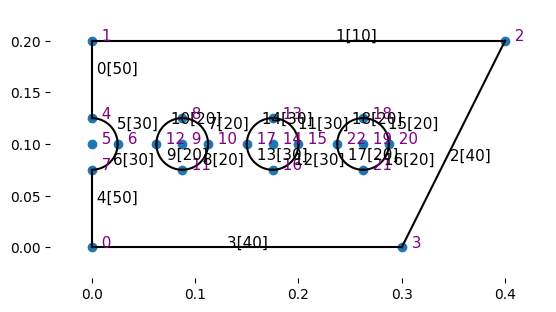

In [15]:
g = cfg.Geometry() #Create geometry

MARKER_TOP = 10
MARKER_CIRCLE_IN = 20
MARKER_CIRCLE_OUT = 30
MARKER_SIDE_AND_BOTTOM = 40
MARKER_SYMMETRY_LINE = 50


g.point([0.0, 0.0]) # point 0
g.point([0.0, 0.200]) # point 1
g.point([0.400, 0.200]) # point 2
g.point([0.300, 0.0]) # point 3

g.point([0, 0.125]) # point 4
g.point([0, 0.100]) # center circle 1; point 5
g.point([0.025, 0.100])# point 6
g.point([0, 0.075]) # point 7

g.point([0.0875, 0.125]) # point 8
g.point([0.0875, 0.100]) # center circle 2; point 9
g.point([0.1125, 0.100]) # point 10
g.point([0.0875, 0.075]) # point 11
g.point([0.0625, 0.100]) # point 12

g.point([0.175, 0.125]) # point 13
g.point([0.175, 0.100]) # center circle 3; point 14
g.point([0.200, 0.100]) #  point 15
g.point([0.175, 0.075]) # point 16
g.point([0.150, 0.100]) # point 17

g.point([0.2625, 0.125]) # point 18
g.point([0.2625, 0.100]) # center circle 3; point 19
g.point([0.2875, 0.100]) #  point 20
g.point([0.2625, 0.075]) # point 21
g.point([0.2375, 0.100]) # point 22


g.spline([4, 1], marker=MARKER_SYMMETRY_LINE)
g.spline([1, 2], marker=MARKER_TOP)
g.spline([2, 3], marker=MARKER_SIDE_AND_BOTTOM)
g.spline([3, 0], marker=MARKER_SIDE_AND_BOTTOM)
g.spline([0, 7], marker=MARKER_SYMMETRY_LINE)

#circle 1
g.circle([4, 5, 6], marker=MARKER_CIRCLE_OUT) 
g.circle([6, 5, 7], marker=MARKER_CIRCLE_OUT)

#circle 2
g.circle([8, 9, 10], marker=MARKER_CIRCLE_IN) 
g.circle([10, 9, 11], marker=MARKER_CIRCLE_IN)
g.circle([11, 9, 12], marker=MARKER_CIRCLE_IN) 
g.circle([12, 9, 8], marker=MARKER_CIRCLE_IN)

#circle 3
g.circle([13, 14, 15], marker=MARKER_CIRCLE_OUT) 
g.circle([15, 14, 16], marker=MARKER_CIRCLE_OUT)
g.circle([16, 14, 17], marker=MARKER_CIRCLE_OUT) 
g.circle([17, 14, 13], marker=MARKER_CIRCLE_OUT)

#circle 4
g.circle([18, 19, 20], marker=MARKER_CIRCLE_IN) 
g.circle([20, 19, 21], marker=MARKER_CIRCLE_IN)
g.circle([21, 19, 22], marker=MARKER_CIRCLE_IN) 
g.circle([22, 19, 18], marker=MARKER_CIRCLE_IN)


g.surface([0, 1, 2, 3, 4, 6, 5], ([7, 8, 9,10], [11,12,13,14], [15,16,17,18]))
cfv.draw_geometry(g)
cfv.show_and_wait()

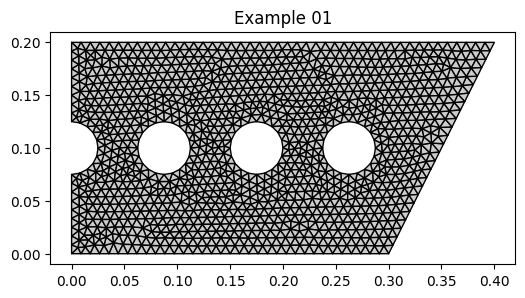

In [16]:
mesh = cfm.GmshMesh(g)

mesh.el_type = 2         # Element type is triangle
mesh.dofs_per_node = 1     # Degrees of freedom per node
mesh.el_size_factor = 0.020  # Element size Factor

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

cfv.figure()
cfv.drawMesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofsPerNode,
    el_type=mesh.elType,
    filled=True,
    title="Example 01"
        )
cfv.show()

In [17]:
def stationary_temp(dofs, coords, edof, bdofs):
    nDofs = np.size(dofs)
    ex, ey = cfc.coordxtr(edof, coords, dofs)

    K = np.zeros([nDofs, nDofs])
    f = np.zeros([nDofs, 1])

    for eltopo, elx, ely in zip(edof, ex, ey):
        Ke = cfc.flw2te(elx, ely, [t], D)
        cfc.assem(eltopo, K, Ke)
        
        for i in range(3):
            for j in range(i+1, 3):
                fe = 0
                Kce = np.zeros((2,2))
                if eltopo[i] in bdofs[MARKER_TOP] and eltopo[j] in bdofs[MARKER_TOP]:
                    # do convection things
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])
                    fe += T_inf*t*alpha_n*dist/2 
                    Kce = alpha_n*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                elif (eltopo[i] in bdofs[MARKER_CIRCLE_IN] and eltopo[j] in bdofs[MARKER_CIRCLE_IN]):
                    # do const flux
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])
                    fe += T_in*t*alpha_c*dist/2
                    Kce = alpha_c*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                elif eltopo[i] in bdofs[MARKER_CIRCLE_OUT] and eltopo[j] in bdofs[MARKER_CIRCLE_OUT]:
                    # do const flux
                    dist = np.linalg.norm(coords[eltopo[i]-1]-coords[eltopo[j]-1])
                    fe += T_out*t*alpha_c*dist/2
                    Kce = alpha_c*t*dist*np.array([[2, 1], [1, 2]])/6
                    
                cfc.assem(np.array([eltopo[i], eltopo[j]]), K, Kce)
                f[eltopo[i]-1] += fe
                f[eltopo[j]-1] += fe
    return K, f

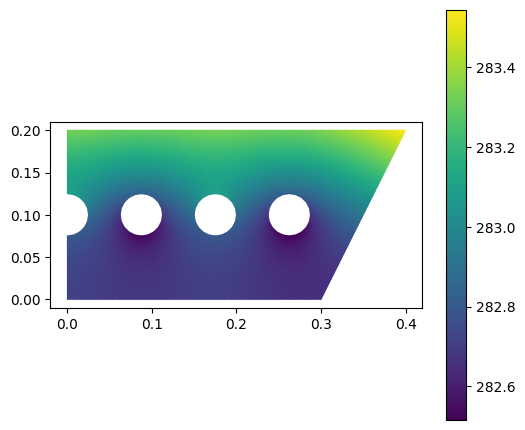

In [18]:
K, f = stationary_temp(dofs, coords, edof, bdofs)
bc = np.array([],'i')
bcVal = np.array([],'f')

# Solving system
a, r = cfc.solveq(K, f, bc, bcVal)

cfv.figure()
cfv.draw_nodal_values_shaded(a, coords, edof)
cfv.colorbar()
cfv.show()


In [19]:
def transient_step(C, K, f, dt, a_old):
    bc = np.array([],'i')
    bcVal = np.array([],'f')
    a_new = np.linalg.solve(C+dt*K, C@a_old+dt*f)
    return a_new

def transient_temp(tend, number_of_steps, dofs, coords, edof, bdofs, charge_func):
    K, fb = stationary_temp(dofs, coords, edof, bdofs)
    
    nDofs = np.size(dofs)
    ex, ey = cfc.coordxtr(edof, coords, dofs)
    
    C = np.zeros((nDofs, nDofs))
    for eltopo, elx, ely in zip(edof, ex, ey):
        Ce = plantml(elx, ely, p*cp)
        cfc.assem(eltopo, C, Ce)
        
    
    a_old = np.ones([nDofs, 1])*T_0
    
    a = a_old
    
    dt = tend/number_of_steps
    
    fl = np.zeros((nDofs,1))
    for eltopo, elx, ely in zip(edof, ex, ey):
        Cmat = np.vstack((np.ones((3, )), elx, ely))
        A = np.linalg.det(Cmat)/2
        for point in eltopo:
            fl[point-1] += A*t/3
    
    for step in range(number_of_steps):
        print("Current step: ", step)
        a_old = transient_step(C, K, fb+fl*charge_func(step*dt), dt, a_old)
        a = np.hstack((a, a_old))
    
    return a

In [20]:
def tempfunc_one(time):
    return 100*np.exp(-144 * ((600-time)/3600)**2 )*1000

def tempfunc_two(time):
    return (time <= 600)*88.42*1000
    
NUMBER_OF_STEPS = 100
END_TIME = 3600

a = transient_temp(END_TIME, NUMBER_OF_STEPS, dofs, coords, edof, bdofs, tempfunc_two)



Current step:  0
Current step:  1
Current step:  2
Current step:  3
Current step:  4
Current step:  5
Current step:  6
Current step:  7
Current step:  8
Current step:  9
Current step:  10
Current step:  11
Current step:  12
Current step:  13
Current step:  14
Current step:  15
Current step:  16
Current step:  17
Current step:  18
Current step:  19
Current step:  20
Current step:  21
Current step:  22
Current step:  23
Current step:  24
Current step:  25
Current step:  26
Current step:  27
Current step:  28
Current step:  29
Current step:  30
Current step:  31
Current step:  32
Current step:  33
Current step:  34
Current step:  35
Current step:  36
Current step:  37
Current step:  38
Current step:  39
Current step:  40
Current step:  41
Current step:  42
Current step:  43
Current step:  44
Current step:  45
Current step:  46
Current step:  47
Current step:  48
Current step:  49
Current step:  50
Current step:  51
Current step:  52
Current step:  53
Current step:  54
Current step:  55
Cu

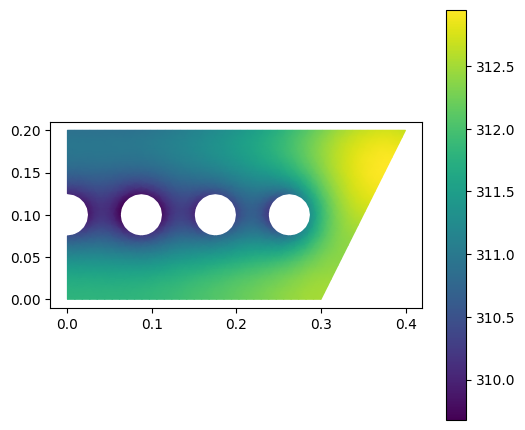

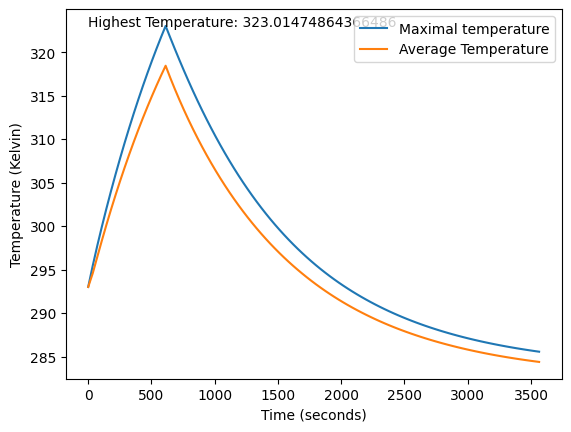

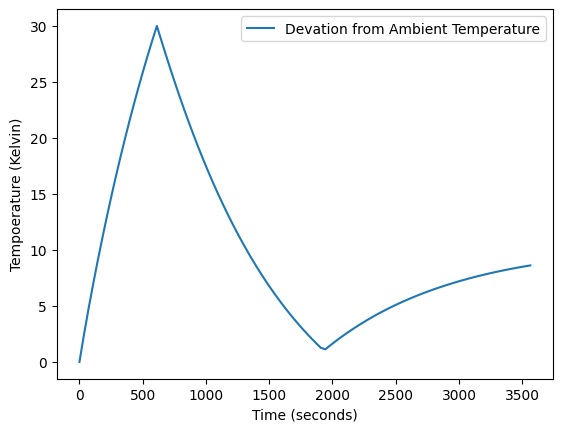

In [57]:
cfv.figure()
cfv.draw_nodal_values_shaded(a[:, 10], coords, edof)
cfv.colorbar()
cfv.show()

def maxtemp():
    max_temp_plot_y = []
    min_temp_plot_y = []
    max_deviation_temp = []
    time_x = []
    max_step = 0
    max_temp = 0
    for step in range(NUMBER_OF_STEPS):
        max_temp_plot_y.append(max(a[:, step]))
        min_temp_plot_y.append(min(a[:, step]))

        deviations_in_a_single_step = []
        temp = 0
        count = 0
        for x in a[:, step]:
            if x > temp:
                temp = x
            deviations_in_a_single_step.append(abs(x-T_inf))
        if temp > max_temp:
            max_temp = temp
            max_step = step
            
        max_deviation_temp.append(max(deviations_in_a_single_step))
        time_x.append(step*(END_TIME/NUMBER_OF_STEPS))
    mpl.plot(time_x, max_temp_plot_y)
    mpl.plot(time_x, min_temp_plot_y)
    x_high, y_high = (time_x[max_temp_plot_y.index(max(max_temp_plot_y))], max(max_temp_plot_y))
    mpl.annotate("Highest Temperature: " + str(y_high), xy=(x_high, y_high), xytext=(0, y_high))
    mpl.legend(["Maximal temperature", "Average Temperature"])
    mpl.ylabel("Temperature (Kelvin)")
    mpl.xlabel("Time (seconds)")
    mpl.show

    mpl.figure()
    mpl.plot(time_x, max_deviation_temp)
    mpl.legend(["Devation from Ambient Temperature"])
    mpl.ylabel("Tempoerature (Kelvin)")
    mpl.xlabel("Time (seconds)")
    mpl.show
    return max_temp, max_step
    
max_temp, max_step = maxtemp()


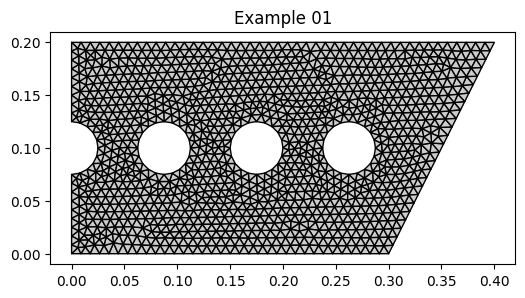

In [22]:

mesh.dofs_per_node = 2     # Degrees of freedom per node
coords2d, edof2d, dofs2d, bdofs2d, elementmarkers = mesh.create()

cfv.figure()
cfv.drawMesh(
    coords=coords2d,
    edof=edof2d,
    dofs_per_node=mesh.dofsPerNode,
    el_type=mesh.elType,
    filled=True,
    title="Example 01"
    )
cfv.show()

In [62]:
def calc_displacement(coords, edof, dofs, bdofs, edof1d, delta_temp):
    
    ep = [2, t]
    D = cfc.hooke(ep[0], E, v)[np.ix_([0, 1, 3], [0, 1, 3])]
    
    
    nDofs = np.size(dofs)
    K = np.zeros([nDofs, nDofs])
    f = np.zeros((nDofs, 1))
    
    ex, ey = cfc.coordxtr(edof, coords, dofs)

    for eltopo, eltopo1d, elx, ely, elMarker in zip(edof, edof1d, ex, ey, elementmarkers):
        
        Ke = cfc.plante(elx, ely, ep, D)
        
        temp = np.abs(((delta_temp[eltopo1d[0]-1] + delta_temp[eltopo1d[1]-1] + delta_temp[eltopo1d[2]-1])/3)-T_0)
        edT = temp*alpha*np.array([[1],
                                   [1],
                                   [0]])
        ro = D@edT
        ftemp = cfc.plantf(elx, ely, ep, ro.T)
        cfc.assem(eltopo, K, Ke, f, ftemp)
        
        
                
                
    bc = np.array([], 'i')
    bcVal = np.array([], 'i')
    bc, bcVal = cfu.applybc(bdofs, bc, bcVal, MARKER_SIDE_AND_BOTTOM, 0.0, 0)
    bc, bcVal = cfu.applybc(bdofs, bc, bcVal, MARKER_SYMMETRY_LINE, 0.0, 1)
    
    a, r =  cfc.solveq(K, f, bc, bcVal)       
    
    ed = cfc.extract_eldisp(edof, a)
    von_mises = []
    for i in range(edof.shape[0]):
        es, et = cfc.plants(ex[i,:], ey[i,:], ep, D, ed[i,:])
        
    # Sure correct?
    von_mises.append( np.math.sqrt( pow(es[0,0],2) + pow(es[0,1],2) - es[0,0]*es[0,1]  + 3*pow(es[0,2],2) ) )
    cfv.figure(fig_size=(10,10))
    cfv.draw_displacements(a, coords, edof, 2, 2,
                      draw_undisplaced_mesh=False, title="Displacements",
                      magnfac=25.0)
    
    cfv.figure(fig_size=(10,10))
    cfv.draw_element_values(von_mises, coords, edof, 2, 2, a,
                      draw_elements=True, draw_undisplaced_mesh=False,
                      title="Effective Stress", magnfac=25.0)

    cfv.colorbar()

C:\Users\Herma\AppData\Local\Temp\ipykernel_2604\2792240029.py:41: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  von_mises.append( np.math.sqrt( pow(es[0,0],2) + pow(es[0,1],2) - es[0,0]*es[0,1]  + 3*pow(es[0,2],2) ) )


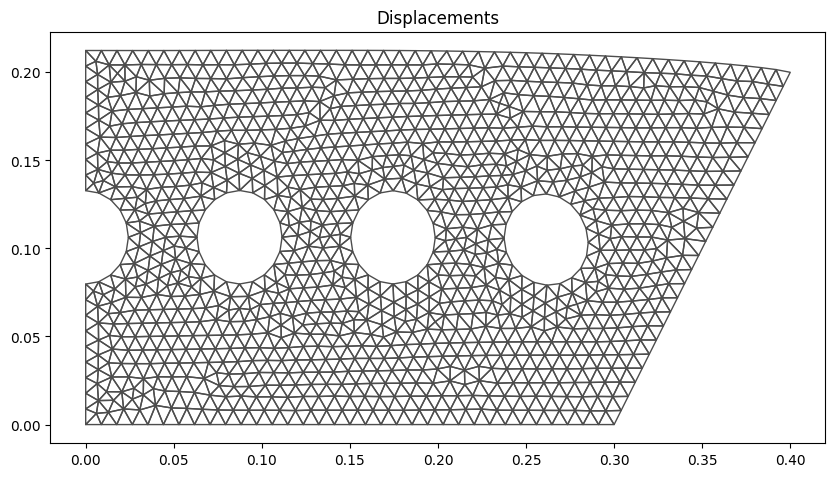

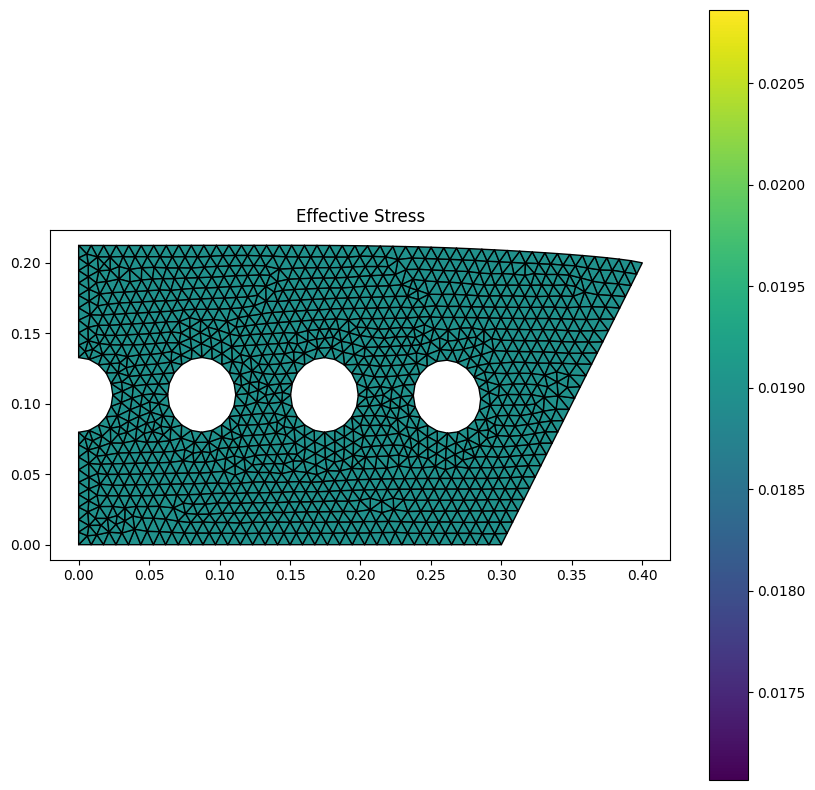

In [63]:
calc_displacement(coords2d, edof2d, dofs2d, bdofs2d, edof,  a[:,max_step])
